In [1]:
#!/usr/bin/env python
import argparse
import builtins
import os
import shutil
import copy
import numpy as np

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim
import torchvision.models as models

import sys
sys.path.extend(['..', '.'])
from datasets.dataset_tinyimagenet import load_train, load_val_loader, num_classes_dict
from tools.store import ExperimentLogWriter
import models.builder as model_builder
import utils

from sklearn.cluster import KMeans
from collections import Counter

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

import random

model_names = sorted(name for name in models.__dict__
    if name.islower() and not name.startswith("__")
    and callable(models.__dict__[name]))
model_names += ['resnet18_cifar_variant1']

args = argparse.Namespace(
    dataset='cifar10',
    arch='resnet18_cifar_variant1',
    workers=1,
    epochs=100,
    start_epoch=0,
    batch_size=256,
    lr=30.0,
    schedule=[60, 80],
    momentum=0.9,
    weight_decay=0.0,
    print_freq=10,
    evaluate=False,
    world_size=-1,
    rank=-1,
    dist_url='tcp://224.66.41.62:23456',
    dist_backend='nccl',
    seed=None,
    gpu=None,
    multiprocessing_distributed=False,
    opt='sgd',
    dir='log/spectral/completed-2023-05-13spectral-resnet18-mlp1000-norelu-cifar10-lr003-mu1-log_freq:20',
    num_per_class=int(1e10),
    val_every=5,
    latest_only=True,
    mpd=False,
    dist_url_add=0,
    specific_ckpts=None,
    use_random_labels=False,
    normalize=False,
    nomlp=True,
    aug='standard',
    download=True
)


In [2]:
# Check if the file exists
file_path = "data/embeddings.pt"
if not os.path.exists(file_path):
    print("Embeddings file not found.")
else:
    # Load the embeddings tensor from the file
    embeddings = torch.load(file_path)

    # Print the shape or any other desired information about the loaded embeddings
    print("Loaded embeddings shape:", embeddings.shape)

Loaded embeddings shape: torch.Size([50000, 512])


In [3]:
def flip_labels(labels, flip_ratio, num_classes):
    # We flip labels randomly based on the given ratio
    total_labels = len(labels)
    num_flip = int(total_labels * flip_ratio)

    flip_indices = np.random.choice(total_labels, num_flip, replace=False)
    original_labels = labels.copy()

    for idx in flip_indices:
        labels[idx] = (labels[idx] + np.random.randint(1, num_classes)) % num_classes

    return labels, flip_indices, original_labels

def get_majority_vote_label(labels):
    label_counts = Counter(labels)
    return label_counts.most_common(1)[0][0]

def calculate_accuracy(predicted_labels, actual_labels):
    correct_predictions = (np.array(predicted_labels) == np.array(actual_labels)).sum()
    total_predictions = len(actual_labels)
    accuracy = correct_predictions / total_predictions
    return accuracy

In [4]:
# Load and build the model
# loop through checkpoints and set pre-trained
ckpt_dir = os.path.join(args.dir, 'checkpoints')
for fname in sorted(os.listdir(ckpt_dir)):
    if args.latest_only and not fname.startswith('latest_'): continue
    if args.specific_ckpts is not None and fname not in args.specific_ckpts: continue
    args.pretrained = os.path.join(ckpt_dir, fname)
args.distributed = False

model = model_builder.get_model(num_classes_dict[args.dataset], arch=args.arch)
# load from pre-trained, before DistributedDataParallel constructor
if args.pretrained:
    if os.path.isfile(args.pretrained):
        checkpoint = torch.load(args.pretrained, map_location='cpu')
        state_dict = checkpoint['state_dict']
        model_builder.load_checkpoint(model, state_dict, args.pretrained, args=args, nomlp=args.nomlp)
    else:
        print("=> no checkpoint found at '{}'".format(args.pretrained))

=> loading checkpoint 'log/spectral/completed-2023-05-13spectral-resnet18-mlp1000-norelu-cifar10-lr003-mu1-log_freq:20/checkpoints/latest_800.pth'
=> loaded pre-trained model 'log/spectral/completed-2023-05-13spectral-resnet18-mlp1000-norelu-cifar10-lr003-mu1-log_freq:20/checkpoints/latest_800.pth'


In [5]:
def load_labels(train_loader):
    labels = []
    for _, label in train_loader:
        labels.extend(label.tolist())
    return labels

In [6]:
random_labels = None
train_sampler, train_loader = load_train(args.dataset, args.num_per_class, args.distributed,
                                         args.batch_size, args.workers, data_aug=args.aug, random_labels=random_labels)

# Load original labels
original_labels = load_labels(train_loader)
    

In [7]:
train_loader

In [8]:
# Flip labels
labels, flip_indices, original_labels = flip_labels(original_labels, flip_ratio=0.01, num_classes=10)

In [9]:
num_different_elements = sum(1 for x, y in zip(labels, original_labels) if x != y)
print("Number of different labels:", num_different_elements)

Number of different labels: 500


In [10]:
num_classes = len(set(labels)) # 10
num_clusters = num_classes*1000 # 10000

In [11]:
kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(embeddings)

/Users/jinhuang/opt/miniconda3/envs/spectral/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [31]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import random
import torchvision

data_path_dict = {
    # 'imagenet': get_dataset_path(),
    'tiny-imagenet': 'PATH_TO_DATASET',
    'cifar10': 'PATH_TO_DATASET',
    'cifar100': 'PATH_TO_DATASET'
}

%matplotlib inline

# Load the CIFAR10 dataset with no transformations
original_dataset = torchvision.datasets.CIFAR10(data_path_dict['cifar10'], train=True, download=True)

# # Load the CIFAR10 dataset with transformations for training
# train_transform = obtain_aug(dataset, data_aug, aug_plus)
# train_dataset = torchvision.datasets.CIFAR10(data_path_dict['cifar10'], train=True, transform=train_transform, download=False)

# # Replace the train_loader with a new one that uses the transformed dataset
# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=True)

# Assume num_clusters is the total number of clusters
num_selected_clusters = 5 # Change this to select more or fewer clusters

selected_clusters = []

# Create a list of all labels from the original_dataset
labels = torch.tensor([label for _, label in original_dataset])

Files already downloaded and verified


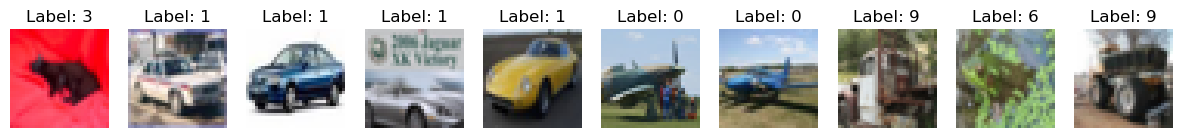

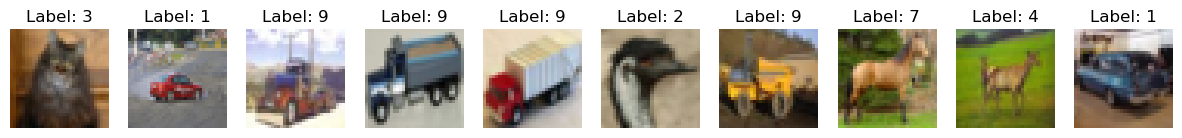

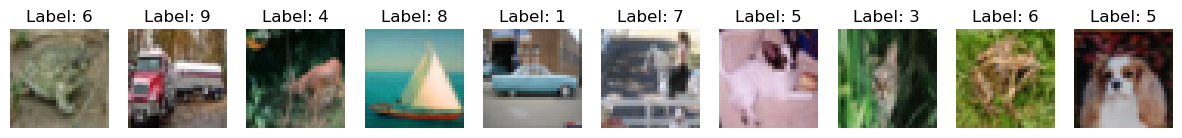

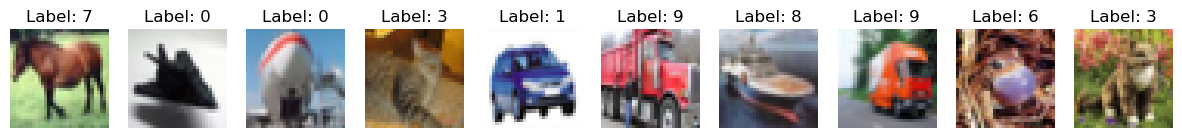

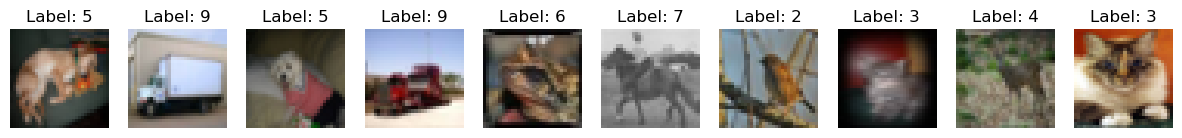

In [33]:


for _ in range(num_selected_clusters):
    # Select a random cluster
    cluster = random.randint(0, num_clusters-1)

    # Ensure that the cluster hasn't been selected before
    if cluster not in selected_clusters:
        selected_clusters.append(cluster)
        
        # Get the indices for the images in this cluster
        cluster_indices = np.where(kmeans.labels_ == cluster)[0]
        cluster_indices = cluster_indices.astype(int)

        # Select the first few images from this cluster
        selected_images = [original_dataset[i][0] for i in cluster_indices[:10]]
        selected_labels = [labels[i] for i in cluster_indices[:10]]

        # Plot the images
        fig, axs = plt.subplots(1, len(selected_images), figsize=(15, 3))
        for i, img in enumerate(selected_images):
            axs[i].imshow(img) # The original images are PIL Images, so we can directly use imshow
            axs[i].set_title(f'Label: {selected_labels[i].item()}')
            axs[i].axis('off')  # To hide the axis values
        plt.show()
